In [1]:
# 기본 패키지 설치
!pip install numpy pandas matplotlib

# nltk
!pip install nltk
# Gensim 및 의존 패키지 설치
!pip install gensim

# spaCy 및 언어 모델 설치
!pip install spacy
!python -m spacy download en_core_web_sm

# 시각화 툴 설치 (pyLDAvis)
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 1.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
## basic
import re
import numpy as np
import pandas as pd
from pprint import pprint

## nltk
import nltk
nltk.download('stopwords')

## Mallet
# import os 
# from gensim.models.wrappers import LdaMallet

# os.environ['MALLET_HOME'] = '/home/lhshrk/py-TopicModeling/Mallet'

## Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /home/lhshrk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
rawdata = pd.read_csv('/home/lhshrk/bim_gis_integration_LDA_analysis/data/dataset_final_20250224.csv', encoding='utf-8')
documents = pd.DataFrame(rawdata)
documents.head()
len(documents)

409

In [72]:
import re
import numpy as np
import pandas as pd
import nltk
import gensim
import spacy
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from nltk.corpus import stopwords
from pprint import pprint

# nltk 불용어 다운로드
nltk.download('stopwords')

# 텍스트 전처리 (소문자 변환)
documents['whole_lower'] = documents['whole'].str.lower()

data = documents['whole_lower'].dropna().values.tolist()

# 불용어 설정
stop_words = stopwords.words('english')
stop_words.extend(['give', 'buildingsmart', 'keynote', 'overview', 'joint', 'iso', 'ogc', 'paper', 'model', 'example', 'research', 'report', 'approach', 'result', 'trend', 'trends', 'from', 'subject', 're', 'edu', 'use', 'early', 'current', 'late', 'korean', 'korea'])

# 텍스트 클리닝
data = [re.sub(r'\S*@\S*\s?', '', sent) for sent in data]  # 이메일 제거
data = [re.sub(r'\s+', ' ', sent) for sent in data]  # 공백 정리
data = [re.sub(r"'", "", sent) for sent in data]  # 따옴표 제거

# 토큰화
def sent_to_words(sentences):
    return [simple_preprocess(str(sentence), deacc=True) for sentence in sentences]

data_words = sent_to_words(data)

# Bigram 및 Trigram 모델
bigram = Phrases(data_words, min_count=5, threshold=100)
trigram = Phrases(bigram[data_words], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# 불용어 제거 및 n-gram 적용
def process_words(texts):
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    return texts

data_words_processed = process_words(data_words)

# Lemmatization (표제어 추출)
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

def lemmatization(texts):
    return [[token.lemma_ for token in nlp(' '.join(doc)) if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']] for doc in texts]

data_lemmatized = lemmatization(data_words_processed)

# 결과 확인
pprint(data_lemmatized[:1])


[nltk_data] Downloading package stopwords to /home/lhshrk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[['bim',
  'technical',
  'keynote',
  'conference',
  'give',
  'standard',
  'effort',
  'bim',
  'context',
  'motivation',
  'strengthen',
  'general',
  'awareness',
  'promote',
  'technical',
  'tr',
  'tr',
  'academia',
  'professional',
  'engineer',
  'tr',
  'develop',
  'present',
  'discuss',
  'detail',
  'identify',
  'barrier',
  'opportunity',
  'suggest',
  'specific',
  'standard',
  'effort',
  'result',
  'tr',
  'relate',
  'standard',
  'mathematical',
  'foundation',
  'software',
  'product',
  'tr',
  'show',
  'diverse',
  'standard',
  'effort',
  'datum',
  'structure',
  'service',
  'content',
  'process',
  'come',
  'digital_twin',
  'built_environment',
  'conclusion',
  'future',
  'anticipate',
  'need',
  'standard',
  'shortly',
  'present',
  'practical',
  'example']]


Number of Topics: 6, Coherence Score: 0.3209
Number of Topics: 7, Coherence Score: 0.3316
Number of Topics: 8, Coherence Score: 0.3528
Optimal Number of Topics: 8


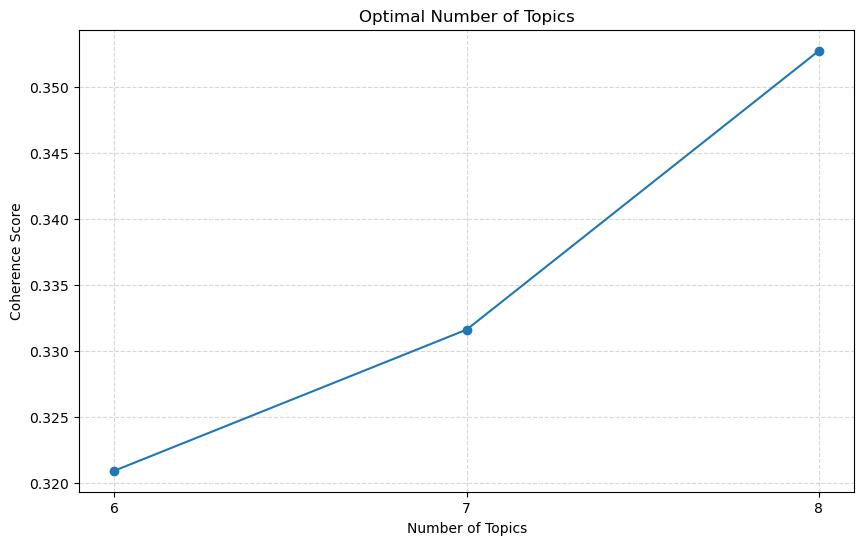

In [112]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel
import matplotlib.pyplot as plt
import gensim.corpora as corpora
import numpy as np
from collections import Counter
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# LDA 수행 전 corpus 및 dictionary 생성
id2word = corpora.Dictionary(data_lemmatized)
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# 최적 토픽 수 선정
min_topics, max_topics = 6, 8
coherence_scores = []

# 우선 괜찮음 topics scope: 2~10까지하면
# for num_topics in range(min_topics, max_topics + 1):
#     model = LdaModel(
#         corpus=corpus, 
#         num_topics=num_topics, 
#         id2word=id2word,
#         random_state=100,
#         chunksize=300,
#         passes=40,
#         iterations=600,
#         alpha='symmetric',
#         eta='auto',
#         minimum_probability=0.05,
#         gamma_threshold=0.01
#         # passes와 iterations를 높히면 중간 값(8)이 올라감
#     )

for num_topics in range(min_topics, max_topics + 1):
    model = LdaModel(
        corpus=corpus, 
        num_topics=num_topics, 
        id2word=id2word,
        random_state=100,
        chunksize=300,
        passes=20,
        iterations=600,
        alpha='symmetric',
        eta='auto',
        minimum_probability=0.05, # 0.005
        gamma_threshold=0.01
        # passes와 iterations를 높히면 중간 값(8)이 올라감
    )
    coherence_model = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    print(f'Number of Topics: {num_topics}, Coherence Score: {coherence_score:.4f}')

# 최적 토픽 수 결정
optimal_topics = coherence_scores.index(max(coherence_scores)) + min_topics
print(f'Optimal Number of Topics: {optimal_topics}')

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(min_topics, max_topics + 1), coherence_scores, marker='o')
plt.xticks(range(min_topics, max_topics + 1))
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Optimal Number of Topics')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Topic 0:  ['indoor', 'location', 'navigation', 'study', 'spatial', 'price', 'type', 'space', 'impact', 'school']
Topic 1:  ['system', 'management', 'information', 'bim', 'base', 'project', 'datum', 'platform', 'use', 'construction']
Topic 2:  ['technology', 'management', 'bim', 'system', 'design', 'information', 'construction', 'study', 'integrate', 'platform']
Topic 3:  ['bim', 'information', 'datum', 'model', 'building', 'city', 'base', 'ifc', 'spatial', 'study']
Topic 4:  ['bim', 'base', 'facility', 'analysis', 'construction', 'design', 'cost', 'study', 'technology', 'use']
Topic 5:  ['datum', 'model', 'standard', 'project', 'implementation', 'base', 'requirement', 'indoor', 'energy', 'map']
Topic 6:  ['index', 'resiliency', 'tract', 'assessment', 'ecological', 'economic', 'land', 'score', 'vulnerability', 'private']
Topic 7:  ['image', 'correlation', 'traffic', 'watershe', 'use', 'method', 'medical', 'robot', 'sketch', 'artefact']


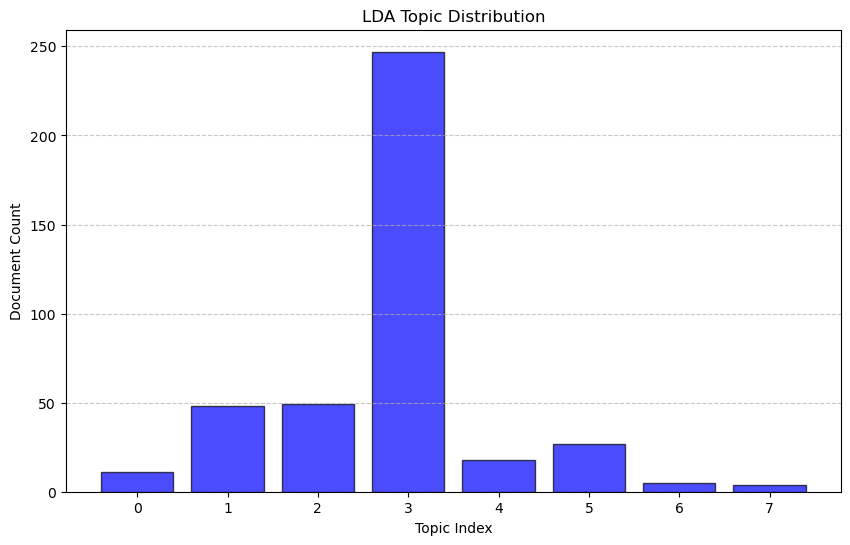

<Figure size 1200x600 with 0 Axes>

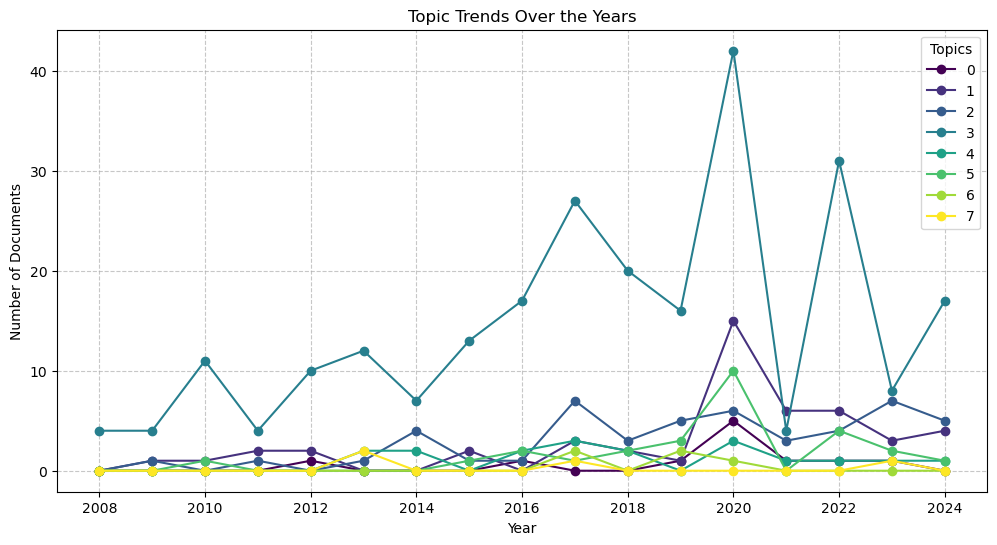


Topic 0: Top 5 Documents
Document ID: 230
Document ID: 288
Document ID: 259
Document ID: 363
Document ID: 386

Topic 1: Top 5 Documents
Document ID: 275
Document ID: 161
Document ID: 296
Document ID: 184
Document ID: 356

Topic 2: Top 5 Documents
Document ID: 272
Document ID: 131
Document ID: 66
Document ID: 391
Document ID: 75

Topic 3: Top 5 Documents
Document ID: 18
Document ID: 186
Document ID: 76
Document ID: 159
Document ID: 65

Topic 4: Top 5 Documents
Document ID: 279
Document ID: 238
Document ID: 337
Document ID: 274
Document ID: 210

Topic 5: Top 5 Documents
Document ID: 222
Document ID: 299
Document ID: 298
Document ID: 228
Document ID: 317

Topic 6: Top 5 Documents
Document ID: 271
Document ID: 283
Document ID: 86
Document ID: 237
Document ID: 384

Topic 7: Top 5 Documents
Document ID: 287
Document ID: 388
Document ID: 277
Document ID: 398


<Figure size 1200x600 with 0 Axes>

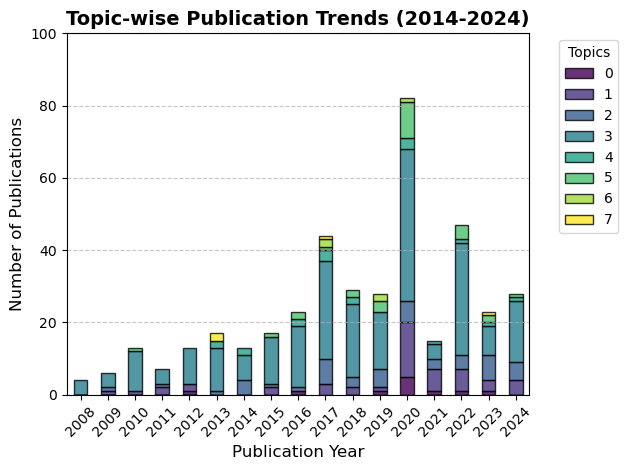

In [113]:
import pandas as pd
import matplotlib.pyplot as plt

# 최적 토픽을 사용한 LDA 모델 학습
lda_model = LdaModel(
    corpus=corpus, 
    num_topics=optimal_topics, 
    id2word=id2word,
    random_state=100,
    chunksize=300,
    passes=20,#20
    iterations=600,
    alpha='symmetric',
    eta='auto',
    minimum_probability=0.05,
    gamma_threshold=0.01
)

# 토픽별 주요 단어 출력
def show_topics(model, num_words=10):
    topics = model.show_topics(num_topics=optimal_topics, num_words=num_words, formatted=False)
    for topic_id, words in topics:
        print(f"Topic {topic_id}: ", [word[0] for word in words])

show_topics(lda_model)

# 📌 LDA 토픽 시각화
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_vis.html')

vis

# 문서별 주요 토픽 할당
major_topics = [max(lda_model.get_document_topics(doc), key=lambda x: x[1])[0] for doc in corpus]
topic_counts = Counter(major_topics)

# 토픽 분포 시각화
plt.figure(figsize=(10, 6))
plt.bar(topic_counts.keys(), topic_counts.values(), color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Topic Index')
plt.ylabel('Document Count')
plt.title('LDA Topic Distribution')
plt.xticks(range(optimal_topics))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 📌 토픽별 연도에 따른 주요 문서 변화 그래프
document_years = documents['Publication_Year'].tolist()
df_topics = pd.DataFrame({'Year': document_years[:len(major_topics)], 'Topic': major_topics})
df_topic_trends = df_topics.groupby(['Year', 'Topic']).size().unstack().fillna(0)

plt.figure(figsize=(12, 6))
df_topic_trends.plot(kind='line', marker='o', colormap='viridis', figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Number of Documents')
plt.title('Topic Trends Over the Years')
plt.legend(title='Topics')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 토픽별 주요 문서 확인 (IDM 기반)
def get_top_documents_per_topic(model, corpus, num_docs=5):
    topic_docs = {i: [] for i in range(optimal_topics)}
    for doc_id, doc in enumerate(corpus):
        topics = model.get_document_topics(doc)
        dominant_topic = max(topics, key=lambda x: x[1])[0]
        topic_docs[dominant_topic].append((doc_id, topics))
    
    for topic, docs in topic_docs.items():
        print(f"\nTopic {topic}: Top {num_docs} Documents")
        for doc_id, _ in sorted(docs, key=lambda x: -max([t[1] for t in x[1]]))[:num_docs]:
            print(f"Document ID: {doc_id}")

get_top_documents_per_topic(lda_model, corpus)

# 📌 토픽별 논문 건수 변화 그래프 (2014~2024)
plt.figure(figsize=(12, 6))
df_topic_trends.plot(kind='bar', stacked=True, colormap='viridis', edgecolor='black', alpha=0.8)

plt.xlabel("Publication Year", fontsize=12)
plt.ylabel("Number of Publications", fontsize=12)
plt.title("Topic-wise Publication Trends (2014-2024)", fontsize=14, fontweight='bold')

plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [109]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.161577 -0.056021       1        1  52.180836
1      0.136960  0.013090       2        1  14.477112
2      0.170887  0.064850       3        1  14.360131
5      0.043209 -0.124752       4        1   7.796586
4     -0.010411  0.163385       5        1   4.629574
0     -0.142469 -0.167518       6        1   3.932031
7     -0.198079  0.090773       7        1   1.427851
6     -0.161673  0.016192       8        1   1.195879, topic_info=            Term        Freq       Total Category  logprob  loglift
4            bim  916.000000  916.000000  Default  30.0000  30.0000
707       indoor  214.000000  214.000000  Default  29.0000  29.0000
261         base  443.000000  443.000000  Default  28.0000  28.0000
109      spatial  261.000000  261.000000  Default  27.0000  27.0000
320   technology  285.000000  285.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
2213          pv    1.822809    6.525229   Topic8  -5.6548   3.1510
2991    fragment    1.662134    4.961696   Topic8  -5.7471   3.3326
1302      public    2.338162   66.796800   Topic8  -5.4058   1.0740
2431         ict    1.652362    7.202458   Topic8  -5.7530   2.9541
2575  prediction    1.749128   20.132196   Topic8  -5.6961   1.9831

[512 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1224      1  0.081955   accident
1224      3  0.819549   accident
3401      3  0.919162   adequate
3484      8  0.844145   advocate
3069      8  0.734589  agreement
...     ...       ...        ...
122       5  0.106698       work
122       6  0.009700       work
498       1  0.411252   workflow
498       4  0.565472   workflow
3998      7  0.729273        zif

[894 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 6, 5, 1, 8, 7])